### 2016 - 2020 Presidential Election Comparison

In [19]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from zipfile import ZipFile

In [20]:
# Helpful constants

# Party colors
COLOR_DEM_BLUE = "#0055A4"
COLOR_REP_RED = "#E9141D"

# How many segments of counties to make, based on size
COUNTY_SEGMENTS = 8

# According to https://ballotpedia.org/Presidential_battleground_states,_2020
# These states were deemed to be competitive in the 2020 election:
BATTLEGROUND_STATES = ["arizona", "florida", "georgia", "iowa", "michigan",
                       "minnesota", "nevada", "new hampshire", "north carolina", 
                       "ohio", "pennsylvania", "texas", "wisconsin"]

# These states went to Trump in 2016, and Biden in 2020:
FLIPPED_STATES = ["pennsylvania", "wisconsin", "michigan", "georgia", "arizona"]

# Column names -- mainly for after cleaning when the names are normalized
COL_ST = "state"
COL_CND = "candidate"
COL_VOTES = "votes"
COL_CNTY = "county"
COL_VOTES_16 = "votes_2016"
COL_VOTES_20 = "votes_2020"
COL_TOT_16 = "total_2016"
COL_TOT_20 = "total_2020"
COL_PCT_16 = "pct_2016"
COL_PCT_20 = "pct_2020"
COL_VOTES_CHG = "votes_change"
COL_PCT_CHG = "percent_change"

# Candidate names, after normalzing Clinton 2016 and Biden 2020 as "the major Democratic candidate",
# Trump as "the major Republican candidate" in both elections, and everone else as "other":
CND_OTHER = "other"
CND_DEM = "the dem"
CND_REP = "trump"

In [21]:
# This is just a function I like using to get an overview of a large data frame:
def print_df_overview(df, title):        
    print(f"{title} DF Head:")
    print(df.head())
    print("----------------------------------")
    print(f"{title} DF dtypes:")
    print(df.dtypes)
    
    for col in df.columns:
        print("----------------------------------")
        print(f"{title} DF column value counts:")

        ABRIDGED_ROWS = 16
        counts = df[col].value_counts()
        if counts.size < 2*ABRIDGED_ROWS:
            # Print the counts all together
            print(col, "counts:")    
            print(counts)
        else:
            # Print top and bottom counts
            print(col, "top counts:")
            print(counts[0:ABRIDGED_ROWS])
            print(col, "bottom counts:")
            print(counts[-ABRIDGED_ROWS:])

In [22]:
# The data files are too big to naively manage in git, so they are stored as zip files.

# Unzip a file to a specified location:
def unzip(zip, where):
    with ZipFile(zip, 'r') as zObject:   
        print(f"Unzipping {zip} to {where}")
        zObject.extractall(path=where) 

# Paths for data files, before and after unzipping
path_2016 = os.path.join('.', 'resources', '2016')
path_2016_csv = os.path.join('.', 'resources', '2016', '2016-precinct-president.csv')
path_2016_zip = os.path.join('.', 'resources', '2016', '2016-precinct-president.csv.zip')
path_2020 = os.path.join('.', 'resources', '2020')
path_2020_csv = os.path.join('.', 'resources', '2020', 'PRESIDENT_precinct_general.csv')
path_2020_zip = os.path.join('.', 'resources', '2020', 'PRESIDENT_precinct_general.csv.zip')

# Unzip the data files
unzip(path_2016_zip, path_2016)
unzip(path_2020_zip, path_2020)

Unzipping .\resources\2016\2016-precinct-president.csv.zip to .\resources\2016
Unzipping .\resources\2020\PRESIDENT_precinct_general.csv.zip to .\resources\2020


In [23]:
# Read raw data -- takes several seconds

# Encoding wasn't documented for 2016 but ISO-8859-1 seems to work fine. 
# Some data types are specified here to suppress warnings
raw_2016_df = pd.read_csv(path_2016_csv, encoding="ISO-8859-1", 
                          dtype={"precinct":str, "district":str, "party":str, "candidate_fec":str, "candidate_fec_name":str, COL_VOTES:int} )

# The 2020 data actually includes the encoding and column data types (thanks!):
official_2020_dtypes = {'precinct':str,'office':str, 'party_detailed':str, 
		'party_simplified':str,'mode':str,'votes':int, 'county_name':str,
		'county_fips':str, 'jurisdiction_name':str,'jurisdiction_fips':str,
		'candidate':str, 'district':str, 'dataverse':str,'year':int,
		'stage':str, 'state':str, 'special':str, 'writein':str, 'state_po':str,
		'state_fips':str, 'state_cen':str, 'state_ic':str, 'date':str, 
		'readme_check':str,'magnitude':int}
raw_2020_df = pd.read_csv(path_2020_csv, encoding="ISO-8859-1", dtype=official_2020_dtypes )

raw_2016_df.shape, raw_2020_df.shape

((1989234, 37), (1982581, 25))

In [24]:
# Get ready to clean up
c_2016_df = raw_2016_df.copy()
c_2020_df = raw_2020_df.copy()
print("Initial:                 ", c_2016_df.shape, c_2020_df.shape)

# There are a few areas which notably DON'T require me to do any special handling:
# write-in votes, straight-ticket voting, and "statistical adjustments"
#
# Evidently write-in and straight-ticket votes have already been tabulated to the right candidate.
# It's odd that some rows don't actually specify a candidate to give the votes to, but if I try to
# do anything special for write-in and straight-ticket votes, I get further from the official totals,
# not closer. So I believe those rows are redundant with respect to candidates' vote totals.
#
# I don't know specifically what "Statistical adjustments" are or why they need their own rows,
# but simply including them consistently brings me closer to the correct totals.

# The 2016 data includes votes for a variety of "offices" with values such as "Straight Ticket",
# and "Unopposed Candidates". I'm not sure exactly what those mean, but the final count is a lot
# closer to the official value without them:
c_2016_df = c_2016_df.loc[c_2016_df["office"] == "US President"]
c_2020_df = c_2020_df.loc[c_2020_df["office"] == "US PRESIDENT"]
print("Drop other offices:      ", c_2016_df.shape, c_2020_df.shape)

# For reasons I do not fathom, there are a lot of -1 votes for various candidates,
# espescially in New Mexico. I have not been able to find out why, so I'm simply dropping them.
# Note some larger negative votes are "statistical adjustments" which are retained.
c_2016_df = c_2016_df.drop(c_2016_df[c_2016_df.votes == -1].index)
c_2020_df = c_2020_df.drop(c_2020_df[c_2020_df.votes == -1].index)
print("Drop negative votes:     ", c_2016_df.shape, c_2020_df.shape)

# Narrow down to the interesting columns.
c_2016_df = c_2016_df.loc[:, [COL_ST, "county_name", COL_CND, COL_VOTES] ]
c_2020_df = c_2020_df.loc[:, [COL_ST, "county_name", COL_CND, COL_VOTES] ]
print("Drop extraneous columns: ", c_2016_df.shape, c_2020_df.shape)

# Change a couple column names for consistency and conciseness
c_2016_df.rename(columns={"county_name": COL_CNTY}, inplace=True)
c_2020_df.rename(columns={"county_name": COL_CNTY}, inplace=True)

# 2016 uses normal capitalization while 2020 uses all caps
# So, California vs CALIFORNIA, and District of Columbia vs DISTRICT OF COLUMBIA
# To reconcile them, force everything to lowercase.
c_2016_df[COL_ST] = c_2016_df[COL_ST].str.lower()
c_2016_df[COL_CNTY] = c_2016_df[COL_CNTY].str.lower()
c_2016_df[COL_CND] = c_2016_df[COL_CND].str.lower()
c_2020_df[COL_ST] = c_2020_df[COL_ST].str.lower()
c_2020_df[COL_CNTY] = c_2020_df[COL_CNTY].str.lower()
c_2020_df[COL_CND] = c_2020_df[COL_CND].str.lower()

# County names actually say "County" in the 2016 data, so remove that
c_2016_df[COL_CNTY] = c_2016_df[COL_CNTY].str.replace(" county", "")

# Reconcile candidate names. Clinton and Biden are equivalent for our purposes, 
# and Biden and Trump both appear in multiple forms in the datasets.
# Any other candidate is just "other".
dem_names = ["hillary clinton", "biden, joe", "joseph biden", "joseph r biden"]
rep_names = ["donald trump", "donald j trump"]
combo = dem_names + rep_names
c_2016_df.loc[~c_2016_df[COL_CND].isin(combo), COL_CND] = CND_OTHER
c_2020_df.loc[~c_2020_df[COL_CND].isin(combo), COL_CND] = CND_OTHER
c_2016_df.loc[c_2016_df[COL_CND].isin(dem_names), COL_CND] = CND_DEM
c_2016_df.loc[c_2016_df[COL_CND].isin(rep_names), COL_CND] = CND_REP
c_2020_df.loc[c_2020_df[COL_CND].isin(dem_names), COL_CND] = CND_DEM
c_2020_df.loc[c_2020_df[COL_CND].isin(rep_names), COL_CND] = CND_REP

Initial:                  (1989234, 37) (1982581, 25)
Drop other offices:       (1954659, 37) (1982581, 25)
Drop negative votes:      (1954656, 37) (1975341, 25)
Drop extraneous columns:  (1954656, 4) (1975341, 4)


In [25]:
# Print out some info to show how much data we lost to cleaning and how it relates to offical results
def before_and_after(year, raw_df, clean_df, dem_raw, dem_official_votes, rep_raw, rep_official_votes, all_official_votes):
    raw_rows = raw_df.shape[0]
    raw_votes = raw_df['votes'].sum()
    clean_rows = clean_df.shape[0]
    clean_votes = clean_df['votes'].sum()

    dem_raw_votes = raw_df.loc[raw_df[COL_CND].str.contains(dem_raw, case=False, na=False)][COL_VOTES].sum()
    dem_clean_votes = clean_df.loc[clean_df[COL_CND] == CND_DEM][COL_VOTES].sum()
    
    rep_raw_votes = raw_df.loc[raw_df[COL_CND].str.contains(rep_raw, case=False, na=False)][COL_VOTES].sum()    
    rep_clean_votes = clean_df.loc[clean_df[COL_CND] == CND_REP][COL_VOTES].sum()
    
    print(f"{year}:")
    print(f"Original: {raw_rows:7} rows, {raw_votes:10} votes")
    print(f"Cleaned:  {clean_rows:7} rows, {clean_votes:10} votes")
    print(f"Democrat Votes (FEC):     {dem_official_votes:10}")
    print(f"Democrat Votes (Raw):     {dem_raw_votes:10} ({dem_raw_votes/dem_official_votes:.3%})")
    print(f"Democrat Votes (Clean):   {dem_clean_votes:10} ({dem_clean_votes/dem_official_votes:.3%})")
    print(f"Republican Votes (FEC):   {rep_official_votes:10}")
    print(f"Republican Votes (Raw):   {rep_raw_votes:10} ({rep_raw_votes/rep_official_votes:.3%})")
    print(f"Republican Votes (Clean): {rep_clean_votes:10} ({rep_clean_votes/rep_official_votes:.3%})")
    print(f"Total Votes (FEC):        {all_official_votes:10}")
    print(f"Total Votes (Raw):        {raw_votes:10} ({raw_votes/all_official_votes:.3%})")
    print(f"Total Votes (Clean):      {clean_votes:10} ({clean_votes/all_official_votes:.3%})")

# Official vote numbers come from the FEC:
#
# FEDERAL ELECTIONS 2016 Election Results for the U.S. President, the U.S. Senate and the U.S. House of Representatives:
# https://www.fec.gov/resources/cms-content/documents/federalelections2016.pdf
# FEDERAL ELECTIONS 2020 Election Results for the U.S. President, the U.S. Senate and the U.S. House of Representatives:
# https://www.fec.gov/resources/cms-content/documents/federalelections2020.pdf
before_and_after(2016, raw_2016_df, c_2016_df, "hillary clinton", 65853514, CND_REP, 62984828, 136669276)
print()
before_and_after(2020, raw_2020_df, c_2020_df, "biden", 81283501, CND_REP, 74223975, 158429631)

2016:
Original: 1989234 rows,  140070880 votes
Cleaned:  1954656 rows,  137103464 votes
Democrat Votes (FEC):       65853514
Democrat Votes (Raw):       65851676 (99.997%)
Democrat Votes (Clean):     65851734 (99.997%)
Republican Votes (FEC):     62984828
Republican Votes (Raw):     62980404 (99.993%)
Republican Votes (Clean):   62980405 (99.993%)
Total Votes (FEC):         136669276
Total Votes (Raw):         140070880 (102.489%)
Total Votes (Clean):       137103464 (100.318%)

2020:
Original: 1982581 rows,  157743486 votes
Cleaned:  1975341 rows,  157750726 votes
Democrat Votes (FEC):       81283501
Democrat Votes (Raw):       80973171 (99.618%)
Democrat Votes (Clean):     80973327 (99.618%)
Republican Votes (FEC):     74223975
Republican Votes (Raw):     73661867 (99.243%)
Republican Votes (Clean):   73662011 (99.243%)
Total Votes (FEC):         158429631
Total Votes (Raw):         157743486 (99.567%)
Total Votes (Clean):       157750726 (99.571%)


In [26]:
# Just some debug output for during development
#print_df_overview(c_2016_df, "2016 Cleaned")
#print_df_overview(c_2020_df, "2020 Cleaned")

In [27]:
# The two dataframes are so large at this point that merging or joining them is problematic.
# I kept running out of memory. So we squash them down a lot first, summing up the votes for
# each candidate in each county. Combining all the CND_OTHER rows reduces dataframe size
# tremendously, making them much easier to deal with:
grouped_2016 = pd.DataFrame(c_2016_df.groupby([COL_ST, COL_CNTY, COL_CND])[COL_VOTES].sum())
grouped_2020 = pd.DataFrame(c_2020_df.groupby([COL_ST, COL_CNTY, COL_CND])[COL_VOTES].sum())
combo_df = pd.merge(grouped_2016, grouped_2020, on=[COL_ST, COL_CNTY, COL_CND], suffixes=["_2016", "_2020"])

# The actions above result in a "multi index" dataframe, which I don't really want.
# So do regular old simple indexing:
combo_df.reset_index(inplace=True)

print_df_overview(combo_df, "Combo DF")

Combo DF DF Head:
     state   county candidate  votes_2016  votes_2020
0  alabama  autauga     other         865         516
1  alabama  autauga   the dem        5936        7503
2  alabama  autauga     trump       18172       19838
3  alabama  baldwin     other        3874        1890
4  alabama  baldwin   the dem       18458       24578
----------------------------------
Combo DF DF dtypes:
state         object
county        object
candidate     object
votes_2016     int32
votes_2020     int32
dtype: object
----------------------------------
Combo DF DF column value counts:
state top counts:
state
texas             762
georgia           477
virginia          399
kentucky          360
missouri          324
kansas            315
illinois          303
north carolina    300
iowa              297
tennessee         285
nebraska          279
ohio              264
minnesota         258
mississippi       246
michigan          243
oklahoma          231
Name: count, dtype: int64
state bottom c

In [28]:
# Add vote totals columns
combo_df[COL_TOT_16] = ""
combo_df[COL_TOT_20] = ""

for state in combo_df[COL_ST].unique():
    state_slice = combo_df.loc[combo_df[COL_ST] == state]
    counties = state_slice[COL_CNTY].unique()
    for county in counties:
        county_slice = state_slice.loc[combo_df[COL_CNTY] == county]        
        total_2016 = county_slice[COL_VOTES_16].sum()
        total_2020 = county_slice[COL_VOTES_20].sum()

        combo_df.loc[county_slice.index, COL_TOT_16] = total_2016
        combo_df.loc[county_slice.index, COL_TOT_20] = total_2020

combo_df

,state,county,candidate,votes_2016,votes_2020,total_2016,total_2020
0,alabama,autauga,other,865,516,24973,27857
1,alabama,autauga,the dem,5936,7503,24973,27857
2,alabama,autauga,trump,18172,19838,24973,27857
3,alabama,baldwin,other,3874,1890,95215,110012
4,alabama,baldwin,the dem,18458,24578,95215,110012
...,...,...,...,...,...,...,...
8954,wyoming,washakie,the dem,532,651,3814,4032
8955,wyoming,washakie,trump,2911,3245,3814,4032
8956,wyoming,weston,other,194,93,3526,3560
8957,wyoming,weston,the dem,299,360,3526,3560


In [29]:
# Add the columns showing percentages and changes from 2016-2020
combo_df[COL_PCT_16] = combo_df[COL_VOTES_16] / combo_df[COL_TOT_16]
combo_df[COL_PCT_20] = combo_df[COL_VOTES_20] / combo_df[COL_TOT_20]
combo_df[COL_VOTES_CHG] = combo_df[COL_VOTES_20] - combo_df[COL_VOTES_16]
combo_df[COL_PCT_CHG] = combo_df[COL_PCT_20] - combo_df[COL_PCT_16]
combo_df

,state,county,candidate,votes_2016,votes_2020,total_2016,total_2020,pct_2016,pct_2020,votes_change,percent_change
0,alabama,autauga,other,865,516,24973,27857,0.034637,0.018523,-349,-0.016114
1,alabama,autauga,the dem,5936,7503,24973,27857,0.237697,0.26934,1567,0.031643
2,alabama,autauga,trump,18172,19838,24973,27857,0.727666,0.712137,1666,-0.015529
3,alabama,baldwin,other,3874,1890,95215,110012,0.040687,0.01718,-1984,-0.023507
4,alabama,baldwin,the dem,18458,24578,95215,110012,0.193856,0.223412,6120,0.029556
...,...,...,...,...,...,...,...,...,...,...,...
8954,wyoming,washakie,the dem,532,651,3814,4032,0.139486,0.161458,119,0.021972
8955,wyoming,washakie,trump,2911,3245,3814,4032,0.763241,0.804812,334,0.041571
8956,wyoming,weston,other,194,93,3526,3560,0.05502,0.026124,-101,-0.028896
8957,wyoming,weston,the dem,299,360,3526,3560,0.084799,0.101124,61,0.016325


In [30]:
# Set up DFs segmented by county size, based on 2020 vote total

# Originally generated by Co-Pilot
def split_df(df, n):
    """
    Splits a DF into N equal-sized (by row) sub-DFs.
    
    Args:
        df (DataFrame): The original dataframe.
        n (int): Number of sub-DFs to create.
    
    Returns:
        list of DFs: A list containing N sub-DFs.
    """
    avg_size = len(df) // n
    remainder = len(df) % n

    results = []
    start = 0
    for i in range(n):
        end = start + avg_size + (1 if i < remainder else 0)
        results.append(df.iloc[start:end,:])
        start = end

    return results

segmented_names = split_df(combo_df.drop_duplicates([COL_ST, COL_CNTY]).sort_values(COL_TOT_20).loc[:, [COL_ST, COL_CNTY] ], COUNTY_SEGMENTS)
segmented_names

segmented_dfs = []
for segment in segmented_names:
    segment_df = pd.DataFrame()
    for index, row in segment.iterrows():
        county_slice = combo_df.loc[(combo_df[COL_CNTY] == row[COL_CNTY]) & (combo_df[COL_ST] == row[COL_ST])]
        if len(county_slice) > 0:
            segment_df = pd.concat([segment_df, county_slice])
    segmented_dfs.append(segment_df)

big_counties_df = segmented_dfs[-1]

# Note how many counties we have data for. This doesn't impact any calculation directly, but is nice to know:
county_count = len(combo_df.drop_duplicates([COL_ST, COL_CNTY]))
big_county_count = len(big_counties_df.drop_duplicates([COL_ST, COL_CNTY]))
county_count, big_county_count

(2988, 186)

In [31]:
# I have a lot of boxplots, and this little function is for adding median values as text
# just above the median line in the box:
def add_percent_above_value(subplot, x, ylim, value, digits=0, color="black"):
    range = ylim[1] - ylim[0]
    voffset = range * 0.015
    subplot.text(x, value + voffset, f"{value:.{digits}%}", va='center', ha='center', color=color, weight='bold')  

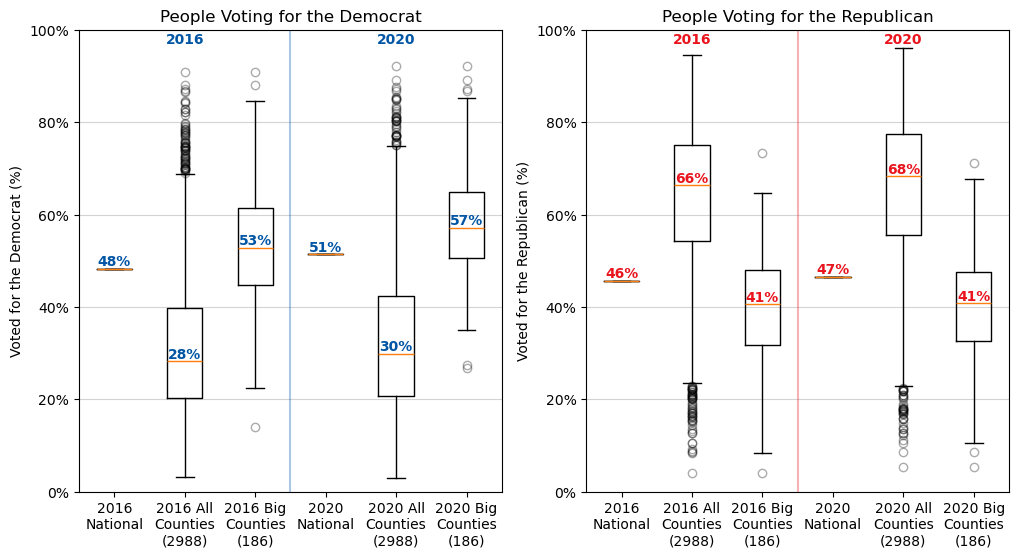

In [32]:
# This function makes a boxplot showing national, all county, and big county percentages
# for both election years:
def plot_result_comparisons(subplot, candidate_str, title, color):
    national_gb = combo_df.groupby(COL_CND).sum()
    candidate = candidate_str

    national_pct_2016 = national_gb[COL_VOTES_16][candidate_str] / national_gb[COL_VOTES_16].sum()
    national_pct_2020 = national_gb[COL_VOTES_20][candidate_str] / national_gb[COL_VOTES_20].sum()

    combo_slice = combo_df.loc[combo_df[COL_CND] == candidate_str]
    big_slice = big_counties_df.loc[big_counties_df[COL_CND] == candidate_str]

    subplot.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.0%}"))

    subplot.boxplot(
            [national_pct_2016, combo_slice[COL_PCT_16], big_slice[COL_PCT_16],
             national_pct_2020, combo_slice[COL_PCT_20], big_slice[COL_PCT_20]],
            flierprops= {"alpha": 0.33} )
    subplot.set_title(f"People Voting for {title}")
    subplot.set_ylabel(f"Voted for {title} (%)")
    subplot.set_ylim((0,1))
    subplot.set_xticklabels(["2016\nNational", f"2016 All\nCounties\n({county_count})", f"2016 Big\nCounties\n({big_county_count})", 
                             "2020\nNational", f"2020 All\nCounties\n({county_count})", f"2020 Big\nCounties\n({big_county_count})"])
    subplot.grid(axis="y", which="major", color="lightgrey")

    # Divide the years
    subplot.axvline(3.5, color=color, alpha=0.33)
    subplot.text(2, 0.98, "2016", va="center", ha="center", color=color, weight="bold")
    subplot.text(5, 0.98, "2020", va="center", ha="center", color=color, weight="bold")

    add_percent_above_value(subplot, 1, subplot.get_ylim(), national_pct_2016, color=color)
    add_percent_above_value(subplot, 2, subplot.get_ylim(), combo_slice[COL_PCT_16].median(), color=color)
    add_percent_above_value(subplot, 3, subplot.get_ylim(), big_slice[COL_PCT_16].median(), color=color)
    add_percent_above_value(subplot, 4, subplot.get_ylim(), national_pct_2020, color=color)
    add_percent_above_value(subplot, 5, subplot.get_ylim(), combo_slice[COL_PCT_20].median(), color=color)
    add_percent_above_value(subplot, 6, subplot.get_ylim(), big_slice[COL_PCT_20].median(), color=color)

# Side-by-size boxplots for results for both major candidates:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
plot_result_comparisons(ax1, CND_DEM, "the Democrat", COLOR_DEM_BLUE)
plot_result_comparisons(ax2, CND_REP, "the Republican", COLOR_REP_RED)
plt.savefig("major_results.png")
plt.show()

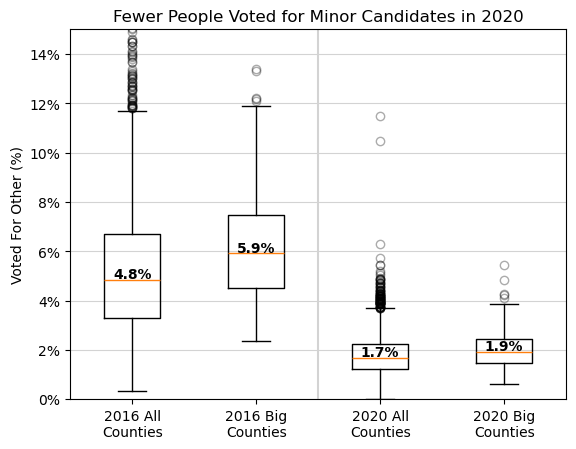

In [33]:
# Show a boxplot for people voting for CND_OTHER candidates, meaning anyone but the two
# main party nominees, in 2016 and 2020.
combo_slice = combo_df.loc[combo_df[COL_CND] == CND_OTHER]
big_slice = big_counties_df.loc[big_counties_df[COL_CND] == CND_OTHER]

plt.axes().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.0%}"))
plt.boxplot(
    [combo_slice[COL_PCT_16], big_slice[COL_PCT_16], combo_slice[COL_PCT_20], big_slice[COL_PCT_20]],
    flierprops= {"alpha": 0.33} )
plt.title("Fewer People Voted for Minor Candidates in 2020")
plt.ylabel("Voted For Other (%)")
plt.ylim((0,0.15))
plt.grid(axis="y", which="major", color="lightgrey")
plt.xticks([1,2,3,4], ["2016 All\nCounties", "2016 Big\nCounties", "2020 All\nCounties", "2020 Big\nCounties"])
plt.axvline(2.5, color="lightgrey")

add_percent_above_value(plt, 1, plt.ylim(), combo_slice[COL_PCT_16].median(), digits=1)
add_percent_above_value(plt, 2, plt.ylim(), big_slice[COL_PCT_16].median(), digits=1)
add_percent_above_value(plt, 3, plt.ylim(), combo_slice[COL_PCT_20].median(), digits=1)
add_percent_above_value(plt, 4, plt.ylim(), big_slice[COL_PCT_20].median(), digits=1)

plt.savefig("minor_results.png")
plt.show()

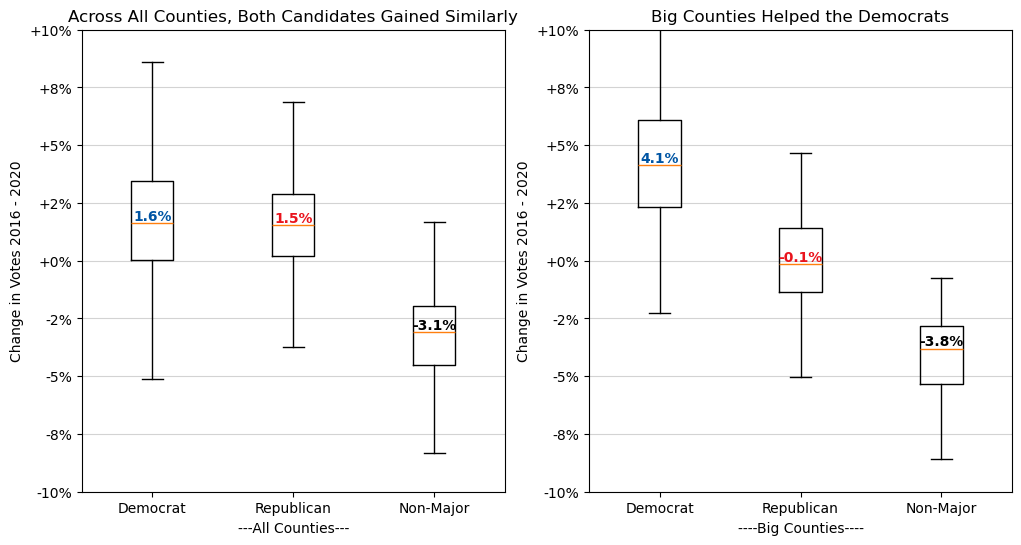

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,6))

ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:+.0%}"))
ax1.boxplot(
        [combo_df.loc[combo_df[COL_CND] == CND_DEM][COL_PCT_CHG], 
         combo_df.loc[combo_df[COL_CND] == CND_REP][COL_PCT_CHG],
         combo_df.loc[combo_df[COL_CND] == CND_OTHER][COL_PCT_CHG]],
        showfliers=False )
ax1.set_title("Across All Counties, Both Candidates Gained Similarly")
ax1.set_ylabel("Change in Votes 2016 - 2020")
ax1.set_xlabel("---All Counties---")
ax1.set_ylim((-.1,.1))
ax1.set_xticklabels(["Democrat", "Republican", "Non-Major"])
ax1.grid(axis="y", which="major", color="lightgrey")


add_percent_above_value(ax1, 1, ax1.get_ylim(), combo_df.loc[combo_df[COL_CND] == CND_DEM][COL_PCT_CHG].median(), digits=1, color=COLOR_DEM_BLUE)
add_percent_above_value(ax1, 2, ax1.get_ylim(), combo_df.loc[combo_df[COL_CND] == CND_REP][COL_PCT_CHG].median(), digits=1, color=COLOR_REP_RED)
add_percent_above_value(ax1, 3, ax1.get_ylim(), combo_df.loc[combo_df[COL_CND] == CND_OTHER][COL_PCT_CHG].median(), digits=1)

ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:+.0%}"))
ax2.boxplot(
        [big_counties_df.loc[big_counties_df[COL_CND] == CND_DEM][COL_PCT_CHG], 
         big_counties_df.loc[big_counties_df[COL_CND] == CND_REP][COL_PCT_CHG],
         big_counties_df.loc[big_counties_df[COL_CND] == CND_OTHER][COL_PCT_CHG]],
        showfliers=False )
ax2.set_title("Big Counties Helped the Democrats")
ax2.set_ylabel("Change in Votes 2016 - 2020")
ax2.set_xlabel("----Big Counties----")
ax2.set_ylim((-.1,.1))
ax2.set_xticklabels(["Democrat", "Republican", "Non-Major"])
ax2.grid(axis="y", which="major", color="lightgrey")

add_percent_above_value(ax2, 1, ax2.get_ylim(), big_counties_df.loc[big_counties_df[COL_CND] == CND_DEM][COL_PCT_CHG].median(), digits=1, color=COLOR_DEM_BLUE)
add_percent_above_value(ax2, 2, ax2.get_ylim(), big_counties_df.loc[big_counties_df[COL_CND] == CND_REP][COL_PCT_CHG].median(), digits=1, color=COLOR_REP_RED)
add_percent_above_value(ax2, 3, ax2.get_ylim(), big_counties_df.loc[big_counties_df[COL_CND] == CND_OTHER][COL_PCT_CHG].median(), digits=1)
plt.savefig("county_shifts.png")
plt.show()

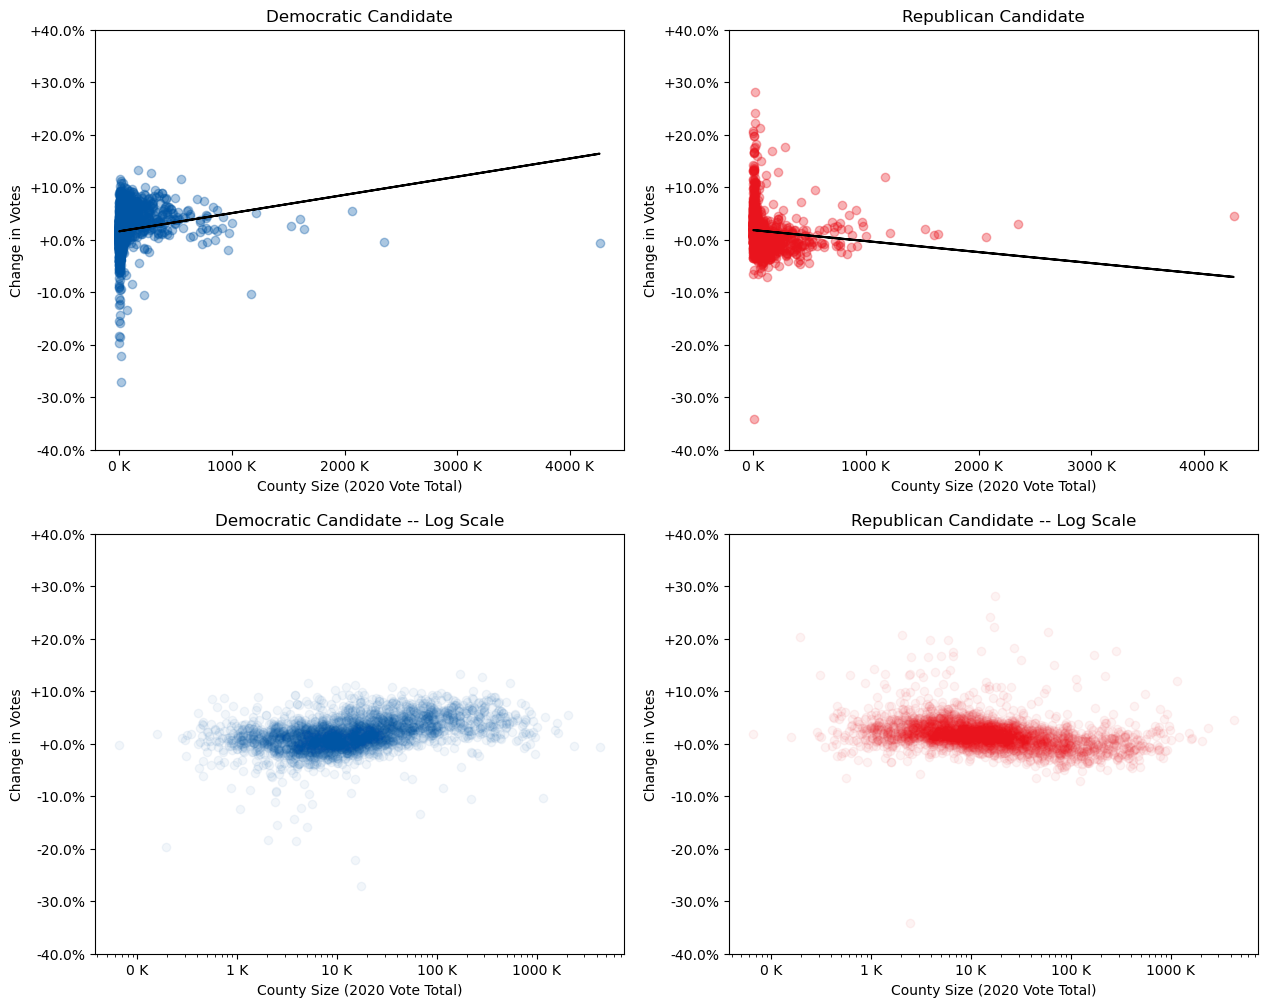

In [35]:
#Scatterplot showing relationship between county size and gain for party
def scatter_party(subplot, candidate_str, title, color, trendcolor, log):
    slice = combo_df.loc[combo_df[COL_CND] == candidate_str]
    x = slice[COL_TOT_20] / 1000
    y = slice[COL_PCT_CHG]
    subplot.set_title(title)

    subplot.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:+.1%}"))    
    subplot.set_title(title)
    subplot.set_ylabel("Change in Votes")
    subplot.set_xlabel("County Size (2020 Vote Total)")
    subplot.set_ylim((-.4, 0.4))

    if log:
        subplot.scatter(x, y, color=color, alpha=0.05)
        subplot.set_xscale("log")
    else:
        subplot.scatter(x, y, color=color, alpha=0.33)
        subplot.set_xscale("linear") # AKA normal
    
        z = np.polyfit(list(x), list(y), 1)
        p = np.poly1d(z)
        subplot.plot(x,p(x),trendcolor)

    subplot.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.0f} K"))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(15,12))
scatter_party(ax1, CND_DEM, "Democratic Candidate", COLOR_DEM_BLUE, "black", False)
scatter_party(ax2, CND_REP, "Republican Candidate", COLOR_REP_RED, "black", False)
scatter_party(ax3, CND_DEM, "Democratic Candidate -- Log Scale", COLOR_DEM_BLUE, "black", True)
scatter_party(ax4, CND_REP, "Republican Candidate -- Log Scale", COLOR_REP_RED, "black", True)
plt.savefig("party_shifts_scatter.png")
plt.show()

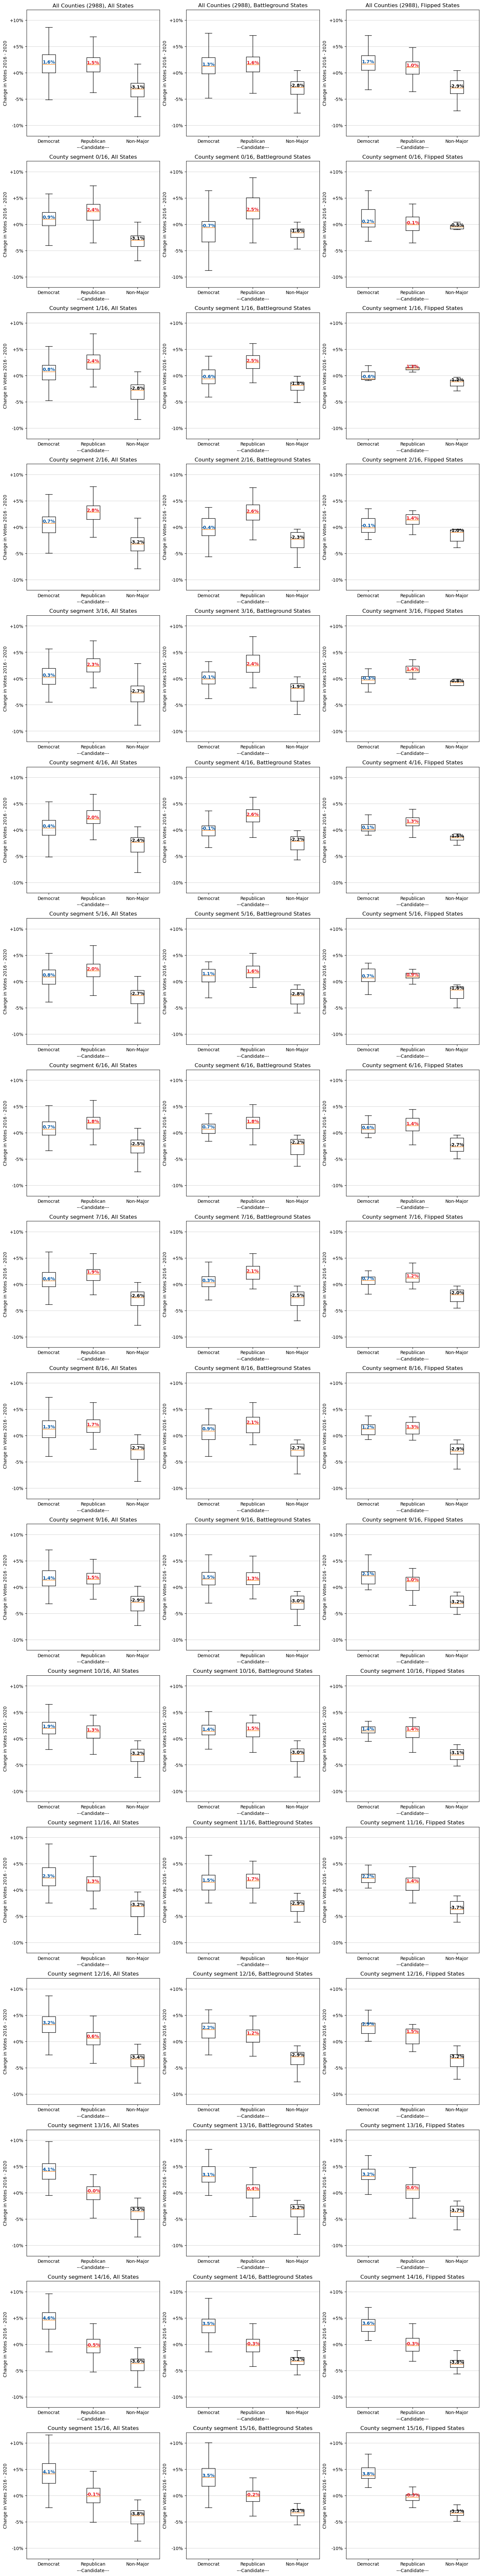

In [46]:
# Show shift betwen dem / rep / other votes in battleground states, flipped states, and the whole country

def plot_shift(df, ax, title):
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:+.0%}"))
    ax.boxplot(
            [df.loc[df[COL_CND] == CND_DEM][COL_PCT_CHG], 
             df.loc[df[COL_CND] == CND_REP][COL_PCT_CHG],
             df.loc[df[COL_CND] == CND_OTHER][COL_PCT_CHG]],
            showfliers=False )
    ax.set_title(title)
    ax.set_ylabel("Change in Votes 2016 - 2020")
    ax.set_xlabel("---Candidate---")
    ax.set_ylim((-.12,.12))
    ax.set_xticklabels(["Democrat", "Republican", "Non-Major"])
    ax.grid(axis="y", which="major", color="lightgrey")    
    
    add_percent_above_value(ax, 1, ax.get_ylim(), df.loc[df[COL_CND] == CND_DEM][COL_PCT_CHG].median(), digits=1, color=COLOR_DEM_BLUE)
    add_percent_above_value(ax, 2, ax.get_ylim(), df.loc[df[COL_CND] == CND_REP][COL_PCT_CHG].median(), digits=1, color=COLOR_REP_RED)
    add_percent_above_value(ax, 3, ax.get_ylim(), df.loc[df[COL_CND] == CND_OTHER][COL_PCT_CHG].median(), digits=1)

battleground_slice = combo_df.loc[combo_df[COL_ST].isin(BATTLEGROUND_STATES)]
flipped_slice = combo_df.loc[combo_df[COL_ST].isin(FLIPPED_STATES)]

big_county_battleground_slice = big_counties_df.loc[big_counties_df[COL_ST].isin(BATTLEGROUND_STATES)]
big_county_flipped_slice = big_counties_df.loc[big_counties_df[COL_ST].isin(FLIPPED_STATES)]

#fig, ( (ax1, ax2, ax3), (ax4, ax5, ax6) ) = plt.subplots(nrows=2,ncols=3,figsize=(18,18))
#plot_shift(combo_df, ax1, f"All Counties ({county_count}), All States")
#plot_shift(battleground_slice, ax2, f"All Counties ({county_count}), Battleground States")
#plot_shift(flipped_slice, ax3, f"All Counties ({county_count}), Flipped States")
#plot_shift(big_counties_df, ax4, f"Big Counties ({big_county_count}), All States")
#plot_shift(big_county_battleground_slice, ax5, f"Big Counties ({big_county_count}), Battleground States")
#plot_shift(big_county_flipped_slice, ax6, f"Big Counties ({big_county_count}), Flipped States")

fig, ( ax ) = plt.subplots(nrows=1+COUNTY_SEGMENTS,ncols=3,figsize=(18,6 * (1+COUNTY_SEGMENTS)))
plot_shift(combo_df, ax[0][0], f"All Counties ({county_count}), All States")
plot_shift(battleground_slice, ax[0][1], f"All Counties ({county_count}), Battleground States")
plot_shift(flipped_slice, ax[0][2], f"All Counties ({county_count}), Flipped States")
for i in range(COUNTY_SEGMENTS):
    title = f"County segment {i}/{COUNTY_SEGMENTS}"
    segment = segmented_dfs[i]
    battleground_slice = segment.loc[segment[COL_ST].isin(BATTLEGROUND_STATES)]
    flipped_slice = segment.loc[segment[COL_ST].isin(FLIPPED_STATES)]
    plot_shift(segment, ax[i+1][0], f"{title}, All States")
    plot_shift(battleground_slice, ax[i+1][1], f"{title}, Battleground States")
    plot_shift(flipped_slice, ax[i+1][2], f"{title}, Flipped States")


plt.savefig("state_shifts.png")
plt.show()